In [1]:
import requests
import re
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import time
import praw
from newspaper import Article
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from wordcloud import WordCloud

/Users/jordankesner/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## NewsAPI Article Collection

In [41]:
queries = {
    "Free Speech": [
        "social media free speech",
        "big tech censorship",
        "social media censorship",
        "platform bias in content moderation",
        "First Amendment and social media",
        "government regulation of online speech",
        "Twitter free speech policies",
        "Facebook content restrictions",
        "social media freedom of expression",
        "censorship of political opinions on social media",
        "banned accounts reinstated social media",
        "Section 230 and online speech",
        "is social media limiting free speech",
        "free speech absolutism on social platforms",
        "self-regulation vs government intervention social media",
        "cancel culture and free speech",
        "academic freedom and social media",
        "lawsuits over social media censorship",
        "does deplatforming violate free speech?",
        "corporate influence on free expression"
    ],
    
    "Hate Speech Regulation": [
        "hate speech regulation social media",
        "misinformation and online hate speech",
        "social media content moderation policies",
        "Facebook Twitter content bans",
        "online harassment and platform responsibility",
        "harmful speech regulation online",
        "hate speech laws and digital platforms",
        "big tech misinformation policies",
        "social media extremism policies",
        "AI moderation of hate speech",
        "freedom of speech vs hate speech",
        "hate speech vs political correctness online",
        "social media toxicity prevention",
        "effectiveness of online content moderation",
        "social media policies on hate speech removal",
        "role of AI in detecting hate speech",
        "harm caused by online radicalization",
        "how misinformation spreads online",
        "regulation of political speech on social media",
        "role of fact-checking in content moderation"
    ],
    
    "Neutral Discussion": [
        "impact of content moderation",
        "how do platforms regulate speech",
        "debate over online free speech policies",
        "government vs private sector role in speech regulation",
        "are social media policies fair?",
        "impact of misinformation on democracy",
        "history of free speech regulation",
        "how do social media platforms enforce policies?",
        "effects of AI-driven content moderation",
        "case studies of social media bans",
        "public opinion on online free speech",
        "legal frameworks for online speech",
        "international laws on free speech and hate speech",
        "role of journalists in free speech regulation",
        "what should be considered hate speech?",
        "difference between hate speech and criticism",
        "impact of content moderation on marginalized groups",
        "debate over removing extremist content",
        "effectiveness of different content moderation strategies",
        "how should misinformation be handled?"
    ],
    
    "Mixed Opinions": [
        "is free speech absolute?",
        "can free speech and moderation coexist?",
        "moderation vs censorship",
        "should governments regulate social media?",
        "social media free speech vs misinformation control",
        "can AI fairly moderate online speech?",
        "balancing user safety and free speech",
        "case studies of controversial deplatforming",
        "big tech vs government in free speech control",
        "how to balance hate speech laws with free speech rights",
        "social media companies' responsibility in free speech debates",
        "is there a middle ground for content moderation?",
        "what does fair content moderation look like?",
        "are online bans justified?",
        "do social media companies over-moderate?",
        "how should anonymous speech be regulated?",
        "content moderation case studies from Facebook and Twitter",
        "who decides what qualifies as hate speech?",
        "should controversial figures be deplatformed?",
        "role of human moderators vs AI in content moderation"
    ]
}


In [ ]:
api_key = "insert your key here"

In [48]:
def fetch_news_articles(queries, max_articles=50):
    """
    Fetches news articles from NewsAPI based on predefined queries.
    
    Parameters:
        queries (dict): Dictionary of category -> list of search queries.
        max_articles (int): Maximum number of articles per category.

    Returns:
        dict: Dictionary with category as key and a list of articles (title, url, source) as values.
    """
    articles_dict = {category: [] for category in queries.keys()}
    
    NEWS_API_URL = "https://newsapi.org/v2/everything"

    for category, query_list in queries.items():
        for query in query_list:
            params = {
                "q": query,
                "language": "en",
                "pageSize": 100,  # Fetch max possible
                "sortBy": "relevancy",
                "apiKey": api_key
            }

            try:
                response = requests.get(NEWS_API_URL, params=params)
                response.raise_for_status()  # Raise error for bad responses
                data = response.json()

                if "articles" in data:
                    for article in data["articles"]:
                        if len(articles_dict[category]) < max_articles:
                            articles_dict[category].append({
                                "title": article.get("title", "No Title"),
                                "url": article.get("url", ""),
                                "source": article.get("source", {}).get("name", "Unknown")
                            })
                
                # Avoid hitting rate limits
                time.sleep(1)

            except requests.exceptions.RequestException as e:
                print(f"Error fetching articles for '{query}': {e}")

    return articles_dict


In [49]:
def extract_full_article_content(article_url, fallback_text):
    """
    Extracts full content from a news article using `newspaper3k`.
    If extraction fails, it falls back to the provided NewsAPI description.

    Parameters:
        article_url (str): The URL of the article.
        fallback_text (str): A fallback description from NewsAPI if content extraction fails.

    Returns:
        str: The full extracted content or the fallback description.
    """
    try:
        article = Article(article_url)
        article.download()
        article.parse()
        if article.text.strip():  # If valid content is found, return it
            return article.text
    except Exception as e:
        print(f"Failed to extract article content from {article_url}: {e}")

    # If newspaper3k fails, return NewsAPI description as fallback
    return fallback_text if fallback_text.strip() else "No content available"


In [50]:
def save_articles_to_corpus(articles_dict, folder_name="NewsAPI Corpus"):
    """
    Saves extracted articles into labeled text files in a corpus folder.

    Parameters:
        articles_dict (dict): Dictionary with categories as keys and articles as values.
        folder_name (str): Destination folder for storing articles.
    """
    os.makedirs(folder_name, exist_ok=True)

    counters = {category: 1 for category in articles_dict.keys()}

    for category, articles in articles_dict.items():
        for article in articles:
            url = article["url"]
            title = article["title"]
            source = article["source"]
            description = article.get("description", "No description available")

            # Extract full article content or use description as fallback
            full_content = extract_full_article_content(url, description)

            # Format the article text
            formatted_text = f"Title: {title}\nSource: {source}\nURL: {url}\n\n{full_content}"

            # Generate a filename
            filename = f"{category.replace(' ', '')}{counters[category]}.txt"
            filepath = os.path.join(folder_name, filename)

            # Save article content
            with open(filepath, "w", encoding="utf-8") as file:
                file.write(formatted_text)

            counters[category] += 1

    print(f"All articles saved in '{folder_name}' successfully!")


In [135]:
articles_data = fetch_news_articles(queries, max_articles=50)

In [52]:
save_articles_to_corpus(articles_data)

⚠️ Failed to extract article content from https://consent.yahoo.com/v2/collectConsent?sessionId=1_cc-session_4e927a1d-def0-4024-8321-0f4ed1f35581: Article `download()` failed with 401 Client Error: Unauthorized for url: https://consent.yahoo.com/v2/collectConsent?sessionId=1_cc-session_4e927a1d-def0-4024-8321-0f4ed1f35581 on URL https://consent.yahoo.com/v2/collectConsent?sessionId=1_cc-session_4e927a1d-def0-4024-8321-0f4ed1f35581
⚠️ Failed to extract article content from https://www.forbes.com/sites/hessiejones/2025/02/13/when-the-truth-no-longer-matters-how-social-medias-engagement-obsession-is-killing-democracy/: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/hessiejones/2025/02/13/when-the-truth-no-longer-matters-how-social-medias-engagement-obsession-is-killing-democracy/ on URL https://www.forbes.com/sites/hessiejones/2025/02/13/when-the-truth-no-longer-matters-how-social-medias-engagement-obsession-is-killing-d

## Reddit API Scraping

In [37]:
reddit = praw.Reddit(
    client_id="zOyg8X3bRR1sZdjAriVG0A",
    client_secret="znhVdzGyTe_4x4Y_pbx4s78c3bi9LQ",
    user_agent="Text Mining Project",
    username="Eastern_Branch8889",
    password="J@episk0d00m6512"
)

In [38]:
# Define queries for each label
queries = {
    "Free Speech": ["social media free speech", "big tech censorship", "online censorship debate"],
    "Hate Speech Regulation": ["hate speech online", "content moderation policies", "social media hate speech regulation"],
    "Neutral Discussion": ["impact of content moderation", "social media free speech study", "how do platforms regulate speech"],
    "Mixed Opinions": ["is free speech absolute?", "can free speech and moderation coexist?", "moderation vs censorship"]
}

# Define subreddits for each label
subreddits = {
    "Free Speech": ["freespeech", "Libertarian", "TrueFreeSpeech", "FreeSpeechDebate"],
    "Hate Speech Regulation": ["socialmedia", "technology", "moderation", "InternetSafety", "news"],
    "Neutral Discussion": ["AskReddit", "PoliticalDiscussion", "Technology", "news"],
    "Mixed Opinions": ["changemyview", "TrueNeutral", "ModeratePolitics", "InternetCulture"]
}

def scrape_reddit_posts(queries, subreddits, limit=50, min_word_count=20):
    """
    Scrapes Reddit posts based on a structured set of queries and subreddits.
    
    Parameters:
        queries (dict): Dictionary mapping labels to their respective search queries.
        subreddits (dict): Dictionary mapping labels to their respective target subreddits.
        limit (int): Max number of posts per query per subreddit.
        min_word_count (int): Minimum words required in a post to be included.

    Returns:
        list: A list of dictionaries containing scraped post data.
    """
    scraped_data = []

    for label, query_list in queries.items():
        for query in query_list:
            for subreddit in subreddits[label]:
                try:
                    print(f"Scraping r/{subreddit} for '{query}' ({label})...")
                    for submission in reddit.subreddit(subreddit).search(query, limit=limit):
                        # Combine title + text for filtering
                        full_text = submission.title + " " + submission.selftext

                        # Ensure post has enough words
                        if len(full_text.split()) < min_word_count:
                            continue

                        post_data = {
                            "subreddit": subreddit,
                            "title": submission.title,
                            "text": submission.selftext,
                            "score": submission.score,
                            "comments": [],
                            "category": label,
                            "url": submission.url
                        }

                        # Fetch top comments
                        submission.comments.replace_more(limit=2)
                        comments = [comment.body for comment in submission.comments.list()[:10] if len(comment.body.split()) >= min_word_count]
                        post_data["comments"] = comments

                        scraped_data.append(post_data)

                except Exception as e:
                    print(f"Error scraping r/{subreddit}: {e}")

    return scraped_data


In [39]:
POST_LIMIT = 40  # Adjust to control dataset size

# Scrape data
reddit_data = scrape_reddit_posts(queries, subreddits, limit=POST_LIMIT)

# Convert to DataFrame
df = pd.DataFrame(reddit_data)

# Save to CSV
df.to_csv("reddit_four_labels.csv", index=False)

print(f"Scraped {len(reddit_data)} posts across all four labels.")

Scraping r/freespeech for 'social media free speech' (Free Speech)...
Scraping r/Libertarian for 'social media free speech' (Free Speech)...
Scraping r/TrueFreeSpeech for 'social media free speech' (Free Speech)...
Scraping r/FreeSpeechDebate for 'social media free speech' (Free Speech)...
Error scraping r/FreeSpeechDebate: received 404 HTTP response
Scraping r/freespeech for 'big tech censorship' (Free Speech)...
Scraping r/Libertarian for 'big tech censorship' (Free Speech)...
Scraping r/TrueFreeSpeech for 'big tech censorship' (Free Speech)...
Scraping r/FreeSpeechDebate for 'big tech censorship' (Free Speech)...
Error scraping r/FreeSpeechDebate: received 404 HTTP response
Scraping r/freespeech for 'online censorship debate' (Free Speech)...
Scraping r/Libertarian for 'online censorship debate' (Free Speech)...
Scraping r/TrueFreeSpeech for 'online censorship debate' (Free Speech)...
Scraping r/FreeSpeechDebate for 'online censorship debate' (Free Speech)...
Error scraping r/FreeSp

In [40]:
def save_reddit_to_corpus(data, folder_name="Reddit Corpus"):
    os.makedirs(folder_name, exist_ok=True)
    
    counters = {"Free Speech": 1, "Hate Speech Regulation": 1, "Neutral Discussion": 1, "Mixed Opinions": 1}

    for post in data:
        category = post["category"]
        title = post["title"]
        text = post["text"]
        comments = "\n".join(post["comments"])

        full_text = f"Title: {title}\n\nPost:\n{text}\n\nTop Comments:\n{comments}"

        filename = f"{category.replace(' ', '')}{counters[category]}.txt"
        filepath = os.path.join(folder_name, filename)

        with open(filepath, "w", encoding="utf-8") as file:
            file.write(full_text)

        counters[category] += 1

    print(f"All Reddit posts saved in '{folder_name}' successfully!")

# Save scraped posts
save_reddit_to_corpus(reddit_data)


✅ All Reddit posts saved in 'Reddit Corpus' successfully!


## Convert All Corpus to CSV

In [53]:


def corpus_to_csv(corpus_folder="NewsAPI Corpus", output_csv="newsapi_dataset.csv"):
    """
    Reads text files from the corpus, extracts structured data, and saves as a CSV.

    Parameters:
        corpus_folder (str): The folder containing text files.
        output_csv (str): The output CSV file name.
    """
    data = []

    # Loop through each text file in the corpus
    for filename in os.listdir(corpus_folder):
        if filename.endswith(".txt"):
            file_path = os.path.join(corpus_folder, filename)

            # Determine label from filename
            if "FreeSpeech" in filename:
                label = "Free Speech"
            elif "HateSpeechRegulation" in filename:
                label = "Hate Speech Regulation"
            elif "NeutralDiscussion" in filename:
                label = "Neutral Discussion"
            elif "MixedOpinions" in filename:
                label = "Mixed Opinions"
            else:
                label = "Unknown"

            with open(file_path, "r", encoding="utf-8") as file:
                content = file.read()

            # Extract structured fields
            title = extract_field(content, "Title:")
            source = extract_field(content, "Source:")
            url = extract_field(content, "URL:")
            article_text = content.split("\n\n", 3)[-1]  # Extracts main article content

            # Store in list
            data.append({
                "Label": label,
                "Title": title,
                "Source": source,
                "URL": url,
                "Content": article_text
            })

    # Convert to DataFrame
    df = pd.DataFrame(data)

    # Save to CSV
    df.to_csv(output_csv, index=False, encoding="utf-8")

    print(f"Corpus successfully converted to {output_csv}")

def extract_field(text, field_name):
    """
    Extracts a specific field (e.g., Title, Source) from the article text.

    Parameters:
        text (str): The full text of the article.
        field_name (str): The field name to extract (e.g., "Title:").

    Returns:
        str: Extracted field value or "Unknown" if not found.
    """
    for line in text.split("\n"):
        if line.startswith(field_name):
            return line.replace(field_name, "").strip()
    return "Unknown"

# Convert Corpus to CSV
corpus_to_csv()


✅ Corpus successfully converted to newsapi_dataset.csv


## CNN Web Scraping

In [54]:
def scrape_cnn_article(url):
    """
    Scrapes the title, publication date, and full content of a CNN article.

    Parameters:
        url (str): The CNN article URL.

    Returns:
        dict: A dictionary containing the article title, date, and content.
    """
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36",
        "Accept-Language": "en-US,en;q=0.9",
        "Accept-Encoding": "gzip, deflate, br",
        "Connection": "keep-alive"
    }

    response = requests.get(url, headers=headers)
    
    if response.status_code != 200:
        print(f"Failed to retrieve the page. Status Code: {response.status_code}")
        return None

    # Parse the HTML content
    soup = BeautifulSoup(response.text, "html.parser")

    # Extract title
    title = soup.find("h1").get_text(strip=True) if soup.find("h1") else "No title found"

    # Extract publication date
    date = soup.find("meta", {"name": "pubdate"}) or soup.find("meta", {"property": "article:published_time"})
    date = date["content"] if date else "No date found"

    # Extract article content from <div class="article__content-container">
    content_container = soup.find("div", class_="article__content-container")
    if content_container:
        paragraphs = content_container.find_all("p")
        content = "\n".join(p.get_text(strip=True) for p in paragraphs)
    else:
        content = "No content found"

    return {
        "title": title,
        "date": date,
        "content": content
    }


In [56]:
article = scrape_cnn_article("https://www.cnn.com/2025/01/07/tech/meta-hateful-conduct-policy-update-fact-check/index.html")

In [57]:
article

{'title': 'Calling women ‘household objects’ now permitted on Facebook after Meta updated its guidelines',
 'date': '2025-01-07T20:36:11.701Z',
 'content': 'Meta on Tuesday announced sweeping changes to how it moderates content that will roll out in the coming months, including doing away with professional fact checking. But the company also quietly updated its hateful conduct policy, adding new types of content users can post on the platform, effective immediately.\nUsers are now allowed to, for example, refer to “women as household objects or property” or “transgender or non-binary people as ‘it,’” according to a section ofthe policyprohibiting such speech that was crossed out. A new section of the policy notes Meta will allow “allegations of mental illness or abnormality when based on gender or sexual orientation, given political and religious discourse about transgenderism and homosexuality.”\nPreviously, such comments would have been subject to removal under the policy. The change

In [55]:
cnn_article_urls = ["https://www.cnn.com/2025/01/07/tech/meta-hateful-conduct-policy-update-fact-check/index.html",
                   "https://www.cnn.com/2025/01/22/media/trump-censorship-executive-order-disinformation/index.html",
                   "https://www.cnn.com/2025/01/13/business/enshittification-internet-meta-nightcap/index.html",
                   "https://www.cnn.com/2025/01/08/health/parents-kids-social-media-meta-wellness/index.html",
                   "https://www.cnn.com/2025/01/23/tech/tech-platforms-hate-speech-eu-vs-us/index.html",
                   "https://www.cnn.com/2025/01/07/tech/meta-censorship-moderation/index.html"]

In [56]:
cnn_articles = []

for url in cnn_article_urls:
    article_content = scrape_cnn_article(url)
    cnn_articles.append(article_content)
    time.sleep(2)

In [9]:
cnn_articles

[{'title': 'Calling women ‘household objects’ now permitted on Facebook after Meta updated its guidelines',
  'date': '2025-01-07T20:36:11.701Z',
  'content': 'Meta on Tuesday announced sweeping changes to how it moderates content that will roll out in the coming months, including doing away with professional fact checking. But the company also quietly updated its hateful conduct policy, adding new types of content users can post on the platform, effective immediately.\nUsers are now allowed to, for example, refer to “women as household objects or property” or “transgender or non-binary people as ‘it,’” according to a section ofthe policyprohibiting such speech that was crossed out. A new section of the policy notes Meta will allow “allegations of mental illness or abnormality when based on gender or sexual orientation, given political and religious discourse about transgenderism and homosexuality.”\nPreviously, such comments would have been subject to removal under the policy. The cha

## CNN Articles to Corpus

In [57]:

def save_cnn_to_corpus(articles, folder_name="CNN Corpus"):
    """
    Saves CNN articles to individual text files in a specified corpus folder.
    
    Parameters:
        articles (list): List of dictionaries containing article data.
        folder_name (str): Name of the folder where text files will be saved.
    """
    os.makedirs(folder_name, exist_ok=True)

    for i, article in enumerate(articles, start=1):
        title = article.get("title", "No Title")
        date = article.get("date", "No Date")
        url = article.get("url", "No URL")
        content = article.get("content", "No Content")

        # Generate a filename
        filename = f"HateSpeechRegulation{i}.txt"
        filepath = os.path.join(folder_name, filename)

        # Save article content to file
        with open(filepath, "w", encoding="utf-8") as file:
            file.write(f"Title: {title}\nDate: {date}\nURL: {url}\n\n{content}")

    print(f"Saved {len(articles)} articles to '{folder_name}'")


In [58]:
save_cnn_to_corpus(cnn_articles)

✅ Saved 6 articles to 'CNN Corpus'


## CNN Articles to CSV

In [59]:
def save_cnn_to_csv(articles, output_csv="cnn_hate_speech.csv"):
    """
    Saves CNN articles as a structured CSV file.

    Parameters:
        articles (list): List of dictionaries containing article data.
        output_csv (str): Name of the CSV file to save.
    """
    # Add the label to each article
    for article in articles:
        article["label"] = "Hate Speech Regulation"

    # Convert to DataFrame
    df = pd.DataFrame(articles)

    # Save to CSV
    df.to_csv(output_csv, index=False, encoding="utf-8")

    print(f"Saved {len(articles)} articles to '{output_csv}'")

In [60]:
save_cnn_to_csv(cnn_articles)

✅ Saved 6 articles to 'cnn_hate_speech.csv'


## Fox News Web Scraping

In [61]:

def scrape_foxnews_article(url):
    """
    Scrapes the title, publication date, and full content of a Fox News article.

    Parameters:
        url (str): The Fox News article URL.

    Returns:
        dict: A dictionary containing the article title, date, and content.
    """
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36",
        "Accept-Language": "en-US,en;q=0.9",
        "Accept-Encoding": "gzip, deflate, br",
        "Connection": "keep-alive"
    }

    response = requests.get(url, headers=headers)

    if response.status_code != 200:
        print(f"Failed to retrieve the page. Status Code: {response.status_code}")
        return None

    # Parse the HTML content
    soup = BeautifulSoup(response.text, "html.parser")

    # Extract title
    title = soup.find("h1", class_="headline")
    title = title.get_text(strip=True) if title else "No title found"

    # Extract publication date
    date = soup.find("meta", {"property": "article:published_time"})
    date = date["content"] if date else "No date found"

    # Extract article content
    content_div = soup.find("div", class_="article-body")
    paragraphs = content_div.find_all("p") if content_div else []
    content = "\n".join(p.get_text(strip=True) for p in paragraphs) if paragraphs else "No content found"

    return {
        "title": title,
        "date": date,
        "content": content,
        "url": url
    }

In [15]:
fox_article = scrape_foxnews_article("https://www.foxnews.com/politics/conservatives-rejoice-over-jaw-dropping-meta-censorship-announcement-huge-win-for-free-speech")

In [16]:
fox_article

{'title': "Conservatives rejoice over 'jaw dropping' Meta censorship announcement: 'Huge win for free speech'",
 'date': 'No date found',
 'content': 'Constitutional law attorney Jonathan Turley provides analysis of Meta CEO Mark Zuckerbergs announcement, where he highlighted a focus on free speech and admitted the Biden administration pressured the company into censorship.\nConservatives on social media took a victory lap on Tuesday in response to the news that Meta had ended its controversial fact-checking practices and promised to move toward a system more focused onfree speech.\n"Meta finally admits to censoring speech…what a great birthday present to wake up to and a huge win for free speech," GOP Sen. Rand Paul posted on X on Tuesday in response to news,first reportedby Fox News Digital, that Meta is ending its fact-checking program and lifting restrictions on speech to "restore free expression" across Facebook, Instagram and Meta platforms, admitting its current content moderati

In [62]:
fox_article_urls = ["https://www.foxnews.com/politics/conservatives-rejoice-over-jaw-dropping-meta-censorship-announcement-huge-win-for-free-speech",
                   "https://www.foxnews.com/entertainment/dave-chappelle-fights-cancel-culture-3-comedians-free-speech-prevail-censorship",
                   "https://www.foxnews.com/us/biden-agency-likely-violated-free-speech-by-working-with-big-tech-to-censor-election-content-court",
                   "https://www.foxnews.com/world/free-speech-advocates-push-elon-musk-fight-state-sponsored-censorship-petition",
                   "https://www.foxnews.com/politics/cpac-alex-berenson-censorship-free-speech-ny-times",
                   "https://www.foxnews.com/opinion/jonathan-turley-metas-zuckerberg-makes-free-speech-move-could-truly-transformational"]

In [63]:
fox_articles = []

for url in fox_article_urls:
    article_content = scrape_foxnews_article(url)
    fox_articles.append(article_content)
    time.sleep(2)

## Fox Articles to Corpus

In [64]:

def save_fox_to_corpus(articles, folder_name="FoxNews Corpus"):
    """
    Saves Fox News articles to individual text files in a specified corpus folder.
    
    Parameters:
        articles (list): List of dictionaries containing article data.
        folder_name (str): Name of the folder where text files will be saved.
    """
    os.makedirs(folder_name, exist_ok=True)

    for i, article in enumerate(articles, start=1):
        title = article.get("title", "No Title")
        date = article.get("date", "No Date")
        url = article.get("url", "No URL")
        content = article.get("content", "No Content")

        # Generate a filename
        filename = f"FreeSpeech{i}.txt"
        filepath = os.path.join(folder_name, filename)

        # Save article content to file
        with open(filepath, "w", encoding="utf-8") as file:
            file.write(f"Title: {title}\nDate: {date}\nURL: {url}\n\n{content}")

    print(f"Saved {len(articles)} articles to '{folder_name}'")

save_fox_to_corpus(fox_articles)

✅ Saved 6 articles to 'FoxNews Corpus'


## Fox Articles to CSV

In [65]:
import pandas as pd

def save_fox_to_csv(articles, output_csv="foxnews_free_speech.csv"):
    """
    Saves Fox News articles as a structured CSV file.

    Parameters:
        articles (list): List of dictionaries containing article data.
        output_csv (str): Name of the CSV file to save.
    """
    # Add the label to each article
    for article in articles:
        article["label"] = "Free Speech"

    # Convert to DataFrame
    df = pd.DataFrame(articles)

    # Save to CSV
    df.to_csv(output_csv, index=False, encoding="utf-8")

    print(f"Saved {len(articles)} articles to '{output_csv}'")

# Save Fox News Articles
save_fox_to_csv(fox_articles)  # Save to CSV


✅ Saved 6 articles to 'foxnews_free_speech.csv'


## CSV to Dataframes

In [91]:
newsapi_df = pd.read_csv("newsapi_dataset.csv")
reddit_df = pd.read_csv("reddit_four_labels.csv")
cnn_df = pd.read_csv("cnn_hate_speech.csv")
foxnews_df = pd.read_csv("foxnews_free_speech.csv")

In [73]:
newsapi_df.head()

,Label,Title,Source,URL,Content
0,Free Speech,How Social Media Brands Can Achieve Relevant D...,Brandingstrategyinsider.com,https://brandingstrategyinsider.com/how-social...,"From a brand standpoint, the more social media..."
1,Free Speech,"Downloads, Trump and VPNs: Everything to Know ...",CNET,https://www.cnet.com/tech/services-and-softwar...,"If the company doesn't sell the app by Sunday,..."
2,Mixed Opinions,2:00PM Water Cooler 1/14/2025,Nakedcapitalism.com,https://www.nakedcapitalism.com/2025/01/200pm-...,"Brown Thrasher, Wannagan Creek Cabin area, Bil..."
3,Hate Speech Regulation,Misinformation as a Business Model—How Meta an...,Newsweek,https://www.newsweek.com/misinformation-busine...,No description available
4,Hate Speech Regulation,Elon Musk is elevating Trump’s foreign policy ...,The Conversation Africa,https://theconversation.com/elon-musk-is-eleva...,"In the past six months, many countries have be..."


In [74]:
reddit_df.head()

,subreddit,title,text,score,comments,category,url
0,freespeech,90% of people have no idea what free speech is,Free speech is your right to say what you want...,961,['But when people are attacked physically or i...,Free Speech,https://www.reddit.com/r/FreeSpeech/comments/n...
1,freespeech,Kamala Harris has stated she will use the Just...,"""We will hold social media platforms accountab...",149,['I’m constantly amazed to meet people who are...,Free Speech,https://www.theverge.com/2019/5/6/18531181/kam...
2,freespeech,The whole Twitter fiasco shows that the left i...,For years the left has censored and shadow ban...,326,"[""Twitter is a private company and liberals ca...",Free Speech,https://www.reddit.com/r/FreeSpeech/comments/u...
3,freespeech,What are your thoughts on the balance between ...,Is misinformation considered free speech or is...,5,"[""The big questions when combating misinformat...",Free Speech,https://www.reddit.com/r/FreeSpeech/comments/1...
4,freespeech,"Why do Nazis, woke people and other enemies of...","""Is speech free?"" is not a synonym for ""what i...",267,['US social media corporations do have links t...,Free Speech,https://www.reddit.com/r/FreeSpeech/comments/o...


In [75]:
cnn_df.head()

,title,date,content,label
0,Calling women ‘household objects’ now permitte...,2025-01-07T20:36:11.701Z,Meta on Tuesday announced sweeping changes to ...,Hate Speech Regulation
1,Disinformation experts blast Trump’s executive...,2025-01-22T13:12:22.364Z,One of President Donald Trump’s first actions ...,Hate Speech Regulation
2,There’s a reason why it feels like the interne...,2025-01-13T14:08:51.614Z,A version of this story appeared in CNN Busine...,Hate Speech Regulation
3,There’s going to be even more harmful content ...,2025-01-08T18:39:41.842Z,Editor’s note:Kara Alaimo is an associate prof...,Hate Speech Regulation
4,Tech giants ramp up the battle against online ...,2025-01-23T10:30:57.701Z,Two of America’s Big Tech companies are openin...,Hate Speech Regulation


In [76]:
foxnews_df.head()

,title,date,content,url,label
0,Conservatives rejoice over 'jaw dropping' Meta...,No date found,Constitutional law attorney Jonathan Turley pr...,https://www.foxnews.com/politics/conservatives...,Free Speech
1,"As Dave Chappelle fights cancel culture, 3 com...",No date found,\nThree comics separately said freedom of spee...,https://www.foxnews.com/entertainment/dave-cha...,Free Speech
2,Biden agency 'likely' violated free speech by ...,No date found,Missouri Attorney General Andrew Bailey reacts...,https://www.foxnews.com/us/biden-agency-likely...,Free Speech
3,Free-speech advocates push Elon Musk to fight ...,No date found,X CEO Elon Musk said he decided to buy the soc...,https://www.foxnews.com/world/free-speech-advo...,Free Speech
4,"Alex Berenson on 'censorship', free speech: 'T...",No date found,"Former New York Times reporter speaks out, rem...",https://www.foxnews.com/politics/cpac-alex-ber...,Free Speech


## Merge into One Dataframe

In [92]:
def standardize_dataframe(df, label_col, text_cols):
    """
    Standardizes a dataframe to have only two columns: Label and Content.
    Uses '---' as a separator between Title and Content.

    Parameters:
        df (pd.DataFrame): The dataframe to standardize.
        label_col (str): The column name that contains the label/category.
        text_cols (list): List of text-based columns to merge into `Content`.

    Returns:
        pd.DataFrame: A cleaned dataframe with two columns: Label and Content.
    """
    # Fill missing values with empty strings
    df[text_cols] = df[text_cols].fillna("")

    # Combine title and content with '---' as a separator
    df["Content"] = df.apply(lambda row: f"{row[text_cols[0]]}\n\n---\n\n{' '.join(row[text_cols[1:]])}", axis=1)

    # Keep only Label and Content columns
    df = df[[label_col, "Content"]].copy()
    df.rename(columns={label_col: "Label"}, inplace=True)
    
    return df


In [93]:
# Standardizing each dataframe

# NewsAPI (Has: Label, Title, Source, URL, Content)
newsapi_df = standardize_dataframe(newsapi_df, label_col="Label", text_cols=["Title", "Content"])

# Reddit (Has: Subreddit, Title, Text, Score, Comments, Category, URL)
reddit_df = standardize_dataframe(reddit_df, label_col="category", text_cols=["title", "text", "comments"])

# CNN (Has: Title, Date, Content, Label)
cnn_df = standardize_dataframe(cnn_df, label_col="label", text_cols=["title", "content"])

# Fox News (Has: Title, Date, Content, URL, Label)
foxnews_df = standardize_dataframe(foxnews_df, label_col="label", text_cols=["title", "content"])


In [94]:
newsapi_df.head()

,Label,Content
0,Free Speech,How Social Media Brands Can Achieve Relevant D...
1,Free Speech,"Downloads, Trump and VPNs: Everything to Know ..."
2,Mixed Opinions,2:00PM Water Cooler 1/14/2025\n\n---\n\nBrown ...
3,Hate Speech Regulation,Misinformation as a Business Model—How Meta an...
4,Hate Speech Regulation,Elon Musk is elevating Trump’s foreign policy ...


In [97]:
reddit_df.head()

,Label,Content
0,Free Speech,90% of people have no idea what free speech is...
1,Free Speech,Kamala Harris has stated she will use the Just...
2,Free Speech,The whole Twitter fiasco shows that the left i...
3,Free Speech,What are your thoughts on the balance between ...
4,Free Speech,"Why do Nazis, woke people and other enemies of..."


In [98]:
combined_df = pd.concat([newsapi_df, reddit_df, cnn_df, foxnews_df], ignore_index=True)


In [99]:
combined_df.shape

(826, 2)

In [100]:
combined_df.to_csv("combined_dataset.csv", index=False, encoding="utf-8")


In [108]:
newsapi_df.to_csv("newsapi_raw_df.csv")

In [109]:
reddit_df.to_csv("reddit_raw_df.csv")

In [110]:
cnn_df.to_csv("cnn_raw_df.csv")

In [111]:
foxnews_df.to_csv("foxnews_raw_df.csv")

## Generate WordClouds for Each Raw Dataframe

In [115]:

def generate_wordcloud_with_countvectorizer(df_dict, max_words=200):
    """
    Generates a word cloud for each dataset using CountVectorizer to count word frequencies.

    Parameters:
        df_dict (dict): Dictionary where keys are dataset names and values are pandas DataFrames.
        max_words (int): Maximum number of words to display in the word cloud.

    Displays:
        A word cloud for each dataset based on word frequencies.
    """
    for name, df in df_dict.items():
        # Extract text from Content column
        text_corpus = df["Content"].dropna().astype(str)

        # Use CountVectorizer to get word frequencies
        vectorizer = CountVectorizer(stop_words="english", max_features=max_words)
        word_matrix = vectorizer.fit_transform(text_corpus)

        # Create dictionary of words and their counts
        word_counts = dict(zip(vectorizer.get_feature_names_out(), word_matrix.toarray().sum(axis=0)))

        # Generate Word Cloud from word counts
        wordcloud = WordCloud(
            width=800, height=400,
            background_color="white",
            colormap="viridis"
        ).generate_from_frequencies(word_counts)

        # Display Word Cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Word Cloud for {name} (Using CountVectorizer)")
        plt.show()


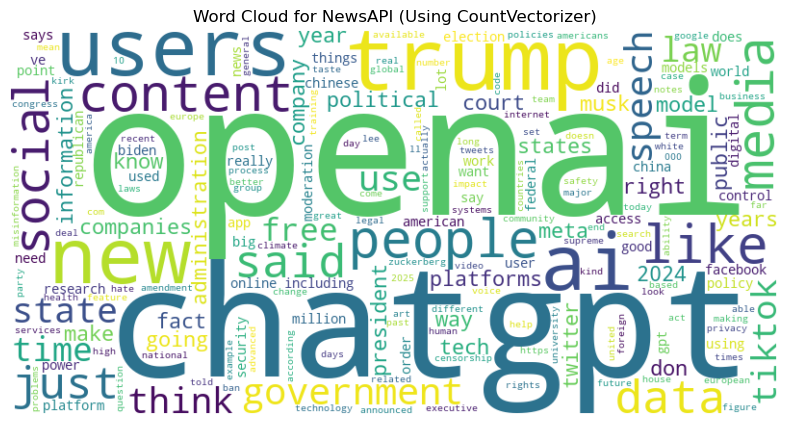

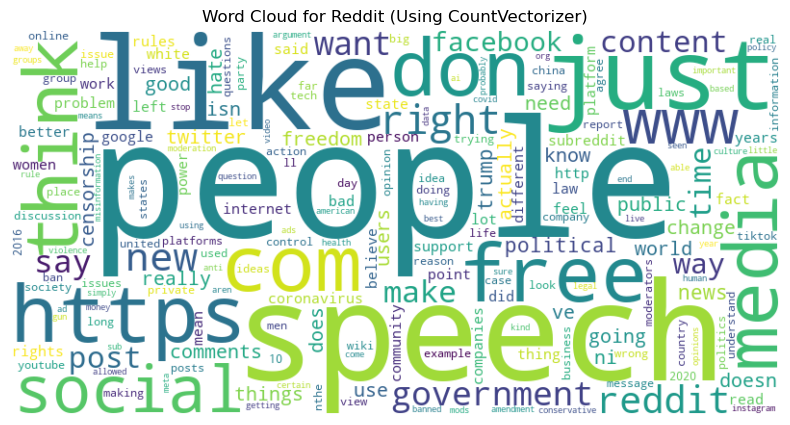

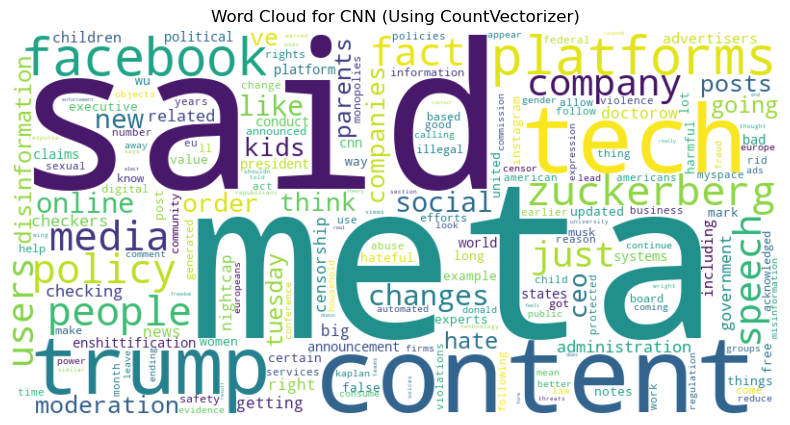

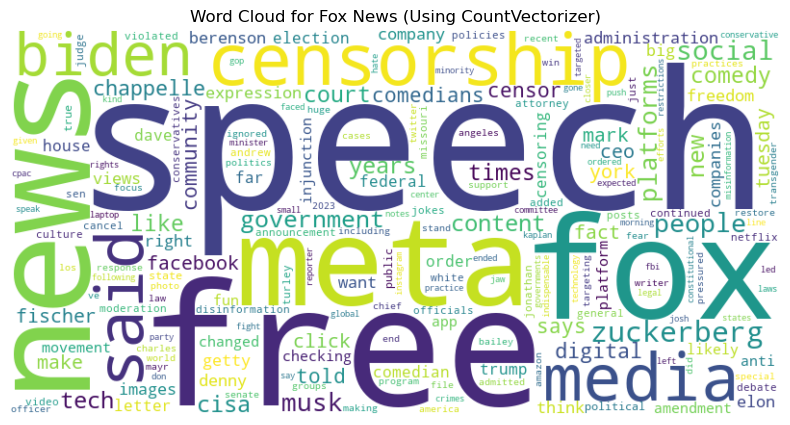

In [116]:
dataframes = {
    "NewsAPI": newsapi_df,
    "Reddit": reddit_df,
    "CNN": cnn_df,
    "Fox News": foxnews_df
}

generate_wordcloud_with_countvectorizer(dataframes)

## Clean Dataframes

In [118]:
import re
import pandas as pd
import nltk
import emoji
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download stopwords if not already installed
nltk.download("stopwords")
nltk.download("punkt")


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jordankesner/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jordankesner/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [119]:
# Define custom stopwords to remove domain-specific words
CUSTOM_STOPWORDS = set([
    "https", "twitter", "facebook", "said", "people", "like", "would", "also", "one", "new", "us", "get","http","says"
]) 

# Combine with NLTK's built-in stopwords
STOPWORDS = set(stopwords.words("english")) | CUSTOM_STOPWORDS

def clean_text(text):
    """
    Cleans text by applying multiple preprocessing steps.

    Parameters:
        text (str): The input text to clean.

    Returns:
        str: The cleaned text.
    """
    if not isinstance(text, str):
        return ""

    # a. Convert text to lowercase
    text = text.lower()

    # b. Get rid of all weird spacing (multiple spaces, newlines)
    text = re.sub(r"\s+", " ", text).strip()

    # c. Tokenize text
    words = word_tokenize(text)

    # d. Remove stopwords
    words = [word for word in words if word not in STOPWORDS]

    # e. Remove punctuation
    words = [re.sub(r"[^\w\s]", "", word) for word in words if word.isalnum()]

    # f. Remove numbers
    words = [word for word in words if not word.isdigit()]

    # g. Remove emojis
    words = [emoji.replace_emoji(word, replace="") for word in words]

    # h. Remove special characters (anything that’s not a letter or AI)
    words = [word for word in words if re.match(r"^[a-zA-Z]+$", word) or word == "AI"]

    # i. Remove two-letter words except "AI"
    words = [word for word in words if len(word) > 2 or word == "AI"]

    return " ".join(words)

def clean_dataframe(df):
    """
    Cleans the 'Content' column in a dataframe.

    Parameters:
        df (pd.DataFrame): The input dataframe.

    Returns:
        pd.DataFrame: The cleaned dataframe.
    """
    df["Content"] = df["Content"].astype(str).apply(clean_text)
    return df

In [121]:
# Apply cleaning function to all datasets
newsapi_cleaned = clean_dataframe(newsapi_df)
reddit_cleaned = clean_dataframe(reddit_df)
cnn_cleaned = clean_dataframe(cnn_df)
foxnews_cleaned = clean_dataframe(foxnews_df)

# Save cleaned versions of the datasets
newsapi_cleaned.to_csv("newsapi_cleaned_df.csv", index=False, encoding="utf-8")
reddit_cleaned.to_csv("reddit_cleaned_df.csv", index=False, encoding="utf-8")
cnn_cleaned.to_csv("cnn_cleaned_df.csv", index=False, encoding="utf-8")
foxnews_cleaned.to_csv("foxnews_cleaned_df.csv", index=False, encoding="utf-8")

print("Cleaned data saved successfully!")


Cleaned data saved successfully!


## WordClouds for Cleaned DFs

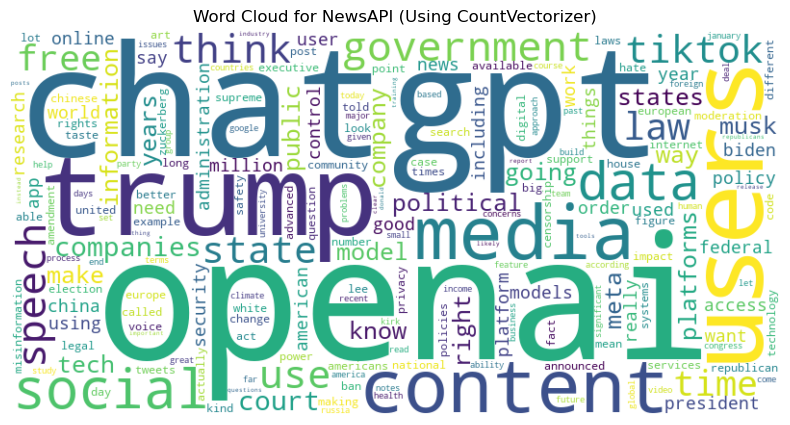

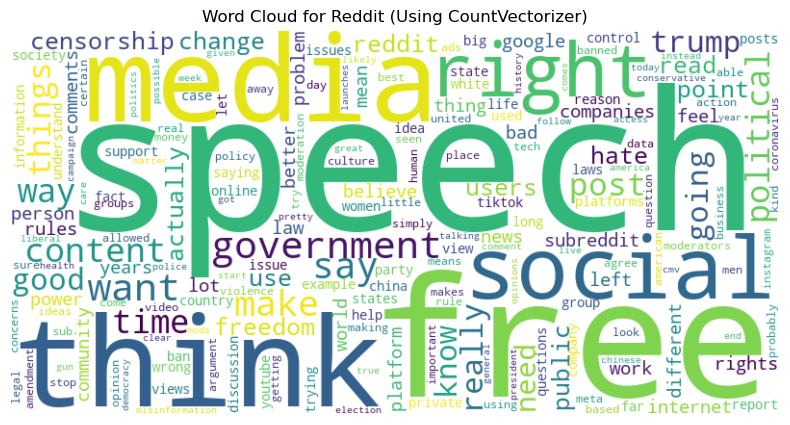

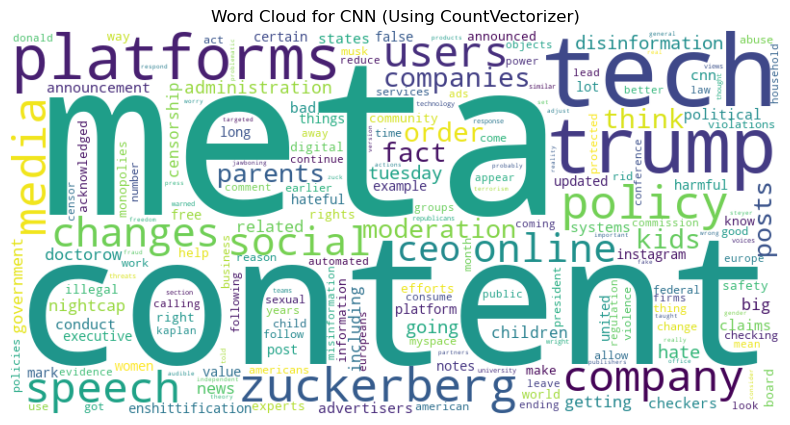

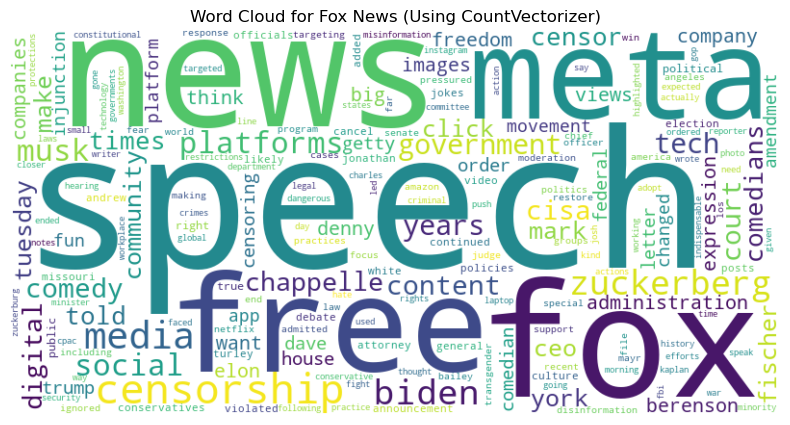

In [123]:
dataframes = {
    "NewsAPI": newsapi_cleaned,
    "Reddit": reddit_cleaned,
    "CNN": cnn_cleaned,
    "Fox News": foxnews_cleaned
}

generate_wordcloud_with_countvectorizer(dataframes)

## Tranforming the Merged Cleaned Dataframe into CountVectorizer, TFIDVectorizer, Stemming, and Lemmatization

In [124]:
cleaned_merged_df = pd.concat([newsapi_cleaned, reddit_cleaned, cnn_cleaned, foxnews_cleaned], ignore_index=True)


In [125]:
cleaned_merged_df.to_csv("cleaned_merged_df.csv")

In [126]:
cleaned_merged_df

,Label,Content
0,Free Speech,social media brands achieve relevant different...
1,Free Speech,downloads trump vpns everything know potential...
2,Mixed Opinions,water cooler brown thrasher wannagan creek cab...
3,Hate Speech Regulation,misinformation business meta musk endanger dem...
4,Hate Speech Regulation,elon musk elevating trump foreign policy delib...
...,...,...
821,Free Speech,dave chappelle fights cancel culture comedians...
822,Free Speech,biden agency violated free speech working big ...
823,Free Speech,advocates push elon musk fight censorship peti...
824,Free Speech,alex berenson free speech changed times change...


In [127]:
import pandas as pd
import numpy as np
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Download necessary NLTK data
nltk.download("punkt")
nltk.download("wordnet")

# Initialize Stemmer and Lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def apply_stemming(text):
    """Applies stemming to a given text."""
    words = word_tokenize(text)
    return " ".join([stemmer.stem(word) for word in words])

def apply_lemmatization(text):
    """Applies lemmatization to a given text."""
    words = word_tokenize(text)
    return " ".join([lemmatizer.lemmatize(word) for word in words])

def vectorize_text(df, method="count"):
    """
    Converts text to numerical vectors using either CountVectorizer or TfidfVectorizer.

    Parameters:
        df (pd.DataFrame): DataFrame with 'Content' column.
        method (str): "count" for CountVectorizer, "tfidf" for TfidfVectorizer.

    Returns:
        pd.DataFrame: DataFrame with vectorized features.
    """
    vectorizer = CountVectorizer() if method == "count" else TfidfVectorizer()
    
    # Fit and transform the text
    text_matrix = vectorizer.fit_transform(df["Content"])
    
    # Convert to DataFrame
    feature_names = vectorizer.get_feature_names_out()
    vectorized_df = pd.DataFrame(text_matrix.toarray(), columns=feature_names)
    
    # Add Labels
    vectorized_df["Label"] = df["Label"].values
    
    return vectorized_df


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jordankesner/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jordankesner/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [128]:
# Load cleaned dataset
cleaned_df = pd.read_csv("cleaned_merged_df.csv")

# Create DataFrames with transformations
stemmed_df = cleaned_df.copy()
stemmed_df["Content"] = stemmed_df["Content"].apply(apply_stemming)

lemmatized_df = cleaned_df.copy()
lemmatized_df["Content"] = lemmatized_df["Content"].apply(apply_lemmatization)

count_vectorized_df = vectorize_text(cleaned_df, method="count")
tfidf_vectorized_df = vectorize_text(cleaned_df, method="tfidf")

# Save transformed DataFrames
stemmed_df.to_csv("stemmed_dataset.csv", index=False)
lemmatized_df.to_csv("lemmatized_dataset.csv", index=False)
count_vectorized_df.to_csv("count_vectorized_dataset.csv", index=False)
tfidf_vectorized_df.to_csv("tfidf_vectorized_dataset.csv", index=False)

print("All processed datasets have been saved successfully.")


All processed datasets have been saved successfully.


## Transforming Individual Data Sources

In [129]:
# Define all datasets
source_datasets = {
    "NewsAPI": newsapi_cleaned,
    "Reddit": reddit_cleaned,
    "CNN": cnn_cleaned,
    "FoxNews": foxnews_cleaned
}

for source_name, df in source_datasets.items():
    # Apply transformations
    stemmed_df = df.copy()
    stemmed_df["Content"] = stemmed_df["Content"].apply(apply_stemming)
    
    lemmatized_df = df.copy()
    lemmatized_df["Content"] = lemmatized_df["Content"].apply(apply_lemmatization)
    
    count_vectorized_df = vectorize_text(df, method="count")
    tfidf_vectorized_df = vectorize_text(df, method="tfidf")

    # Save processed versions
    stemmed_df.to_csv(f"{source_name}_stemmed.csv", index=False)
    lemmatized_df.to_csv(f"{source_name}_lemmatized.csv", index=False)
    count_vectorized_df.to_csv(f"{source_name}_count_vectorized.csv", index=False)
    tfidf_vectorized_df.to_csv(f"{source_name}_tfidf_vectorized.csv", index=False)

    print(f"Processed datasets saved for {source_name}.")


Processed datasets saved for NewsAPI.
Processed datasets saved for Reddit.
Processed datasets saved for CNN.
Processed datasets saved for FoxNews.
